In [29]:
import requests
import json
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
from random import random

import json

import seaborn as sns
sns.set()

from dotenv import load_dotenv
load_dotenv()

DROOT = './data/'
GOOGLE_KEY = os.getenv("GOOGLE_KEY")
CS_KEY = os.getenv("CYCLESTREETS_KEY")

In [30]:
def point2string(point):
    """Returns a lat,lon formatted string from a shapely.geometry.Point."""
    return "{},{}".format(round(point.y, 5), round(point.x, 5))

## Google Maps

In [31]:
def google_query(origin, dest, mode, dstamp):
    
    url = "https://maps.googleapis.com/maps/api/directions/json"
    departure_time = int(dstamp.timestamp())

    modes = ['driving', 'walking', 'bicycling', 'transit']
    assert mode in modes
    
    params = {
        "key": GOOGLE_KEY,
        "origin": "{},{}".format(origin.y, origin.x),
        "destination": "{},{}".format(dest.y, dest.x),
        "mode": mode,
        "units": "metric",
        "departure_time": departure_time

    }
    response = requests.get(url, params=params)

    result = response.json()

    try:
        route = result['routes'][0]['legs'][0]

        details = {
            'distance': route['distance']['value'] / 1000,
            'travelTime': route['duration']['value']
        }

        if 'duration_in_traffic' in route:
            details['travelTime'] = route['duration_in_traffic']['value']
    except: 
        details = {
            'distance': None,
            'travelTime': None
        }
        
    return details

In [32]:
def google_fetch(row):
    
    filepath = os.path.join(
        DROOT, '3-interim', 'th_validation', 'fetched', 
        point2string(row.geometry.centroid) + '_' + point2string(row.destination) + '_google.pcl'
    )
    
    if os.path.exists(filepath):
        row = pd.read_pickle(filepath)
    else:
    
        dep_time = datetime(2020, 7, 7, 8)

        print('.', end='')
        bicycling = google_query(row.geometry.centroid, row.destination, 
                                 'bicycling', dep_time)
        row['bike_d_ggl'] = bicycling['distance']
        row['bike_t_ggl'] = bicycling['travelTime']

        print('.', end='')
        car_r = google_query(row.geometry.centroid, row.destination, 
                                 'driving', dep_time)
        row['car_r_d_ggl'] = car_r['distance']
        row['car_r_t_ggl'] = car_r['travelTime']

        print('.', end='')
        pt_r = google_query(row.geometry.centroid, row.destination, 
                                 'transit', dep_time)
        row['pt_r_d_ggl'] = pt_r['distance']
        row['pt_r_t_ggl'] = pt_r['travelTime']

        print('.', end='')
        walking = google_query(row.geometry.centroid, row.destination, 
                                 'walking', dep_time)
        row['walk_d_ggl'] = walking['distance']
        row['walk_t_ggl'] = walking['travelTime']

        dep_time = datetime(2020, 7, 7, 12)

        print('.', end='')
        car_m = google_query(row.geometry.centroid, row.destination, 
                                 'driving', dep_time)
        row['car_m_d_ggl'] = car_m['distance']
        row['car_m_t_ggl'] = car_m['travelTime']

        print('.', end='')
        pt_m = google_query(row.geometry.centroid, row.destination, 
                                 'transit', dep_time)
        row['pt_m_d_ggl'] = pt_m['distance']
        row['pt_m_t_ggl'] = pt_m['travelTime']

        row.to_pickle(filepath)

    return row

## CycleStreets

In [33]:
def cyclestreets_query(origin, dest):
    
    url = "https://www.cyclestreets.net/api/journey.json"

    params = {
        "key": CS_KEY,
        "itinerarypoints": "{},{}|{},{}".format(
            origin.x, origin.y, dest.x, dest.y),
        "plan": 'balanced',
        "speed": 24

    }
    response = requests.get(url, params=params)

    result = response.json()
    with open('./tmp.json', 'w') as file:
        json.dump(result, file)

    
    try:
        route = result['marker'][0]['@attributes']
        details = {
            'distance': float(route['length']) / 1000,
            'travelTime': float(route['time'])
        }
    except: 
        details = {
            'distance': None,
            'travelTime': None
        }
        
    return details

In [34]:
def cs_fetch(row):
    
    filepath = os.path.join(
        DROOT, '3-interim', 'th_validation', 'fetched', 
        point2string(row.geometry.centroid) + '_' + point2string(row.destination) + '_cs.pcl'
    )
    if os.path.exists(filepath):
        cached = pd.read_pickle(filepath)
        row['bike_d_cs'] = cached['bike_d_cs']
        row['bike_t_cs'] = cached['bike_t_cs']
    else:
        bicycling = cyclestreets_query(row.geometry.centroid, row.destination)
        row['bike_d_cs'] = bicycling['distance']
        row['bike_t_cs'] = bicycling['travelTime']

    row.to_pickle(filepath)
    return row

## Query

In [35]:
# Get all cities to be retrieved from 1.0
city_list_df = pd.read_csv(os.path.join(DROOT, '1-raw', 'citylist.csv'))
city_list_df['geometry'] = city_list_df.apply(
    lambda row: Point(row.ctr_lon, row.ctr_lat), axis=1)
city_list_df = gpd.GeoDataFrame(city_list_df, crs=4326)

gdf_total = gpd.read_file(os.path.join(DROOT, '4-processed', 
                                      'complete-dataset.gpkg'))

In [139]:
# samples_unfiltered
gdf_samples_uf = gpd.GeoDataFrame()

# Get all townhalls generated in 1.1
for cityname, citydf in gdf_total.groupby('city'):

    city_info = city_list_df[city_list_df.City == cityname].iloc[0]
    gdf_sample = citydf.sample(50, random_state=30)
    gdf_sample['destination'] = city_info.geometry

    gdf_samples_uf = gdf_samples_uf.append(gdf_sample)

print(len(gdf_samples_uf), 'samples to be validated.')

gdf_samples_uf.to_pickle(os.path.join(DROOT, '3-interim', 'th_validation', 'th-samples.pcl'))
gdf_samples_uf.sample(2, random_state=5).head()

2850 samples to be validated.


,city,cell_id,cell_pop,sky_d,walk_d,walk_t,pt_r_d,pt_r_t,pt_r_it,pt_m_d,pt_m_t,pt_m_it,bike_d,bike_t,car_r_d,car_r_t,car_m_d,car_m_t,geometry,destination
82241,Budapest,1133,468.773834,2.228325,2.886,2077.0,4.591,1553.0,1176.0,3.857,1383.0,300.0,2.9925,640.0,4.242,991.0,4.242,917.0,"POLYGON ((19.01861 47.52615, 19.01807 47.52380...",POINT (19.02881 47.504423)
20773,Copenhagen,1378,445.682037,4.715185,5.334,3840.0,7.577,1264.0,1200.0,7.577,1264.0,1200.0,5.7902,1195.1,6.741,1081.0,6.741,948.0,"POLYGON ((12.49270 55.68593, 12.49219 55.68342...",POINT (12.5693554 55.6753682)


In [143]:
gdf_samples_uf = gdf_samples_uf.progress_apply(google_fetch, axis=1)
gdf_samples_uf = gdf_samples_uf.progress_apply(cs_fetch, axis=1)
gdf_samples_uf.to_pickle(
    os.path.join(DROOT, '3-interim', 'th_validation', 'th-samples-fetched.pcl'))

..........................................................................................................................................


## Results

In [ ]:
# Remove outliers from the dataset.
gdf_samples = gdf_samples_uf[
    (gdf_samples_uf.pt_r_t_ggl < gdf_samples_uf.pt_r_t_ggl.quantile(0.98))
    & (gdf_samples_uf.pt_r_t < gdf_samples_uf.pt_r_t.quantile(0.98))
    & (gdf_samples_uf.car_r_t < gdf_samples_uf.car_r_t.quantile(0.98))
].copy()

# Add origin centroid
gdf_samples['origin'] = gdf_samples.geometry.centroid

# Transform time units to minutes.
gdf_samples[[
    'walk_t', 'walk_t_ggl',
    'bike_t', 'bike_t_ggl', 'bike_t_cs',
    'car_r_t', 'car_r_t_ggl', 
    'car_m_t', 'car_m_t_ggl',
    'pt_r_t', 'pt_r_t_ggl', 
    'pt_m_t', 'pt_m_t_ggl',
 ]] /= 60

In [ ]:
translate = {
 'walk_t': 'Bing',
 'pt_r_t': 'Bing',
 'pt_m_t': 'Bing',
 'bike_t': 'O R S',
 'car_r_t': 'Bing',
 'car_m_t': 'Bing',
 'bike_t_ggl': 'Google',
 'car_r_t_ggl': 'Google',
 'pt_r_t_ggl': 'Google',
 'walk_t_ggl': 'Google',
 'car_m_t_ggl': 'Google',
 'pt_m_t_ggl': 'Google',
 'bike_t_cs': 'C S',
}

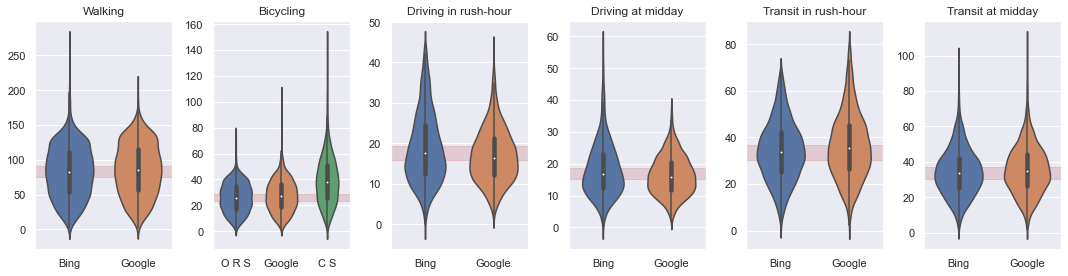

In [115]:
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(12,3), dpi=150, tight_layout=True)
axs = axs.flatten()

# fig.subplots_adjust(top=0.93)
# fig.suptitle('Difference in results, n={}, travel time in seconds.'.format(len(gdf_sample_set)))

lmdn = lambda series: series.median()*0.9
hmdn = lambda series: series.median()*1.1

# First row: Walking, Car (RH) and Transit (RH)
axs[0].axhspan(lmdn(gdf_samples.walk_t), hmdn(gdf_samples.walk_t), 
               color='r', alpha=0.2, zorder=0)
sns.violinplot(data=gdf_samples[['walk_t', 'walk_t_ggl']].rename(columns=translate), 
               width=0.7, ax=axs[0], )
axs[0].set_title('Walking')

axs[1].axhspan(lmdn(gdf_samples.bike_t), hmdn(gdf_samples.bike_t), 
               color='r', alpha=0.2, zorder=0)
sns.violinplot(data=gdf_samples[['bike_t', 'bike_t_ggl', 'bike_t_cs']].rename(columns=translate), 
               width=0.7, ax=axs[1], zorder=2, )
axs[1].set_title('Bicycling')

axs[2].axhspan(lmdn(gdf_samples.car_r_t), hmdn(gdf_samples.car_r_t), 
               color='r', alpha=0.2, zorder=0)
sns.violinplot(data=gdf_samples[['car_r_t', 'car_r_t_ggl']].rename(columns=translate), 
               width=0.7, ax=axs[2], zorder=2)
axs[2].set_title('Driving in rush-hour')

axs[3].axhspan(lmdn(gdf_samples.car_m_t), hmdn(gdf_samples.car_m_t), 
               color='r', alpha=0.2, zorder=0)
sns.violinplot(data=gdf_samples[['car_m_t', 'car_m_t_ggl']].rename(columns=translate), 
               width=0.7, ax=axs[3], zorder=2)
axs[3].set_title('Driving at midday')

axs[4].axhspan(lmdn(gdf_samples.pt_r_t), hmdn(gdf_samples.pt_r_t), 
               color='r', alpha=0.2, zorder=0)
sns.violinplot(data=gdf_samples[['pt_r_t', 'pt_r_t_ggl']].rename(columns=translate), 
               width=0.7, ax=axs[4], zorder=2)
axs[4].set_title('Transit in rush-hour')

axs[5].axhspan(lmdn(gdf_samples.pt_m_t), hmdn(gdf_samples.pt_m_t), 
               color='r', alpha=0.2, zorder=0)
sns.violinplot(data=gdf_samples[['pt_m_t', 'pt_m_t_ggl']].rename(columns=translate), 
               width=0.7, ax=axs[5], zorder=2)
axs[5].set_title('Transit at midday')

# Save figure to disk. 
fig.savefig(
    os.path.join(DROOT, '5-graphs', 'comparing-travel-time-services.png'))
